In [2]:
import os
HOME = os.getcwd()
print(HOME)

d:\Documents\Ki_8\XLA\yolov11_full_v3


Loading model from: d:\Documents\Ki_8\XLA\yolov11_full_v3/runs/detect/train/weights/best.pt
Model classes: {0: 'look_away', 1: 'natural', 2: 'phone', 3: 'rub_eye', 4: 'sleepy_eye', 5: 'yawn'}
Loading CSV from: output_yolo.csv

Bắt đầu dự đoán trên 156 ảnh...
Results saved to yolo_evaluation_output\predict_20250307_222838_031
Ảnh: 20250307_222838_031.jpg - True: look_away, Predicted: look_away (Time: 0.3615s)
Results saved to yolo_evaluation_output\predict_20250307_222838_032
Ảnh: 20250307_222838_032.jpg - True: look_away, Predicted: look_away (Time: 0.0385s)
Results saved to yolo_evaluation_output\predict_20250307_222838_033
Ảnh: 20250307_222838_033.jpg - True: look_away, Predicted: look_away (Time: 0.0393s)
Results saved to yolo_evaluation_output\predict_20250307_222838_034
Ảnh: 20250307_222838_034.jpg - True: look_away, Predicted: look_away (Time: 0.0452s)
Results saved to yolo_evaluation_output\predict_20250307_222838_035
Ảnh: 20250307_222838_035.jpg - True: look_away, Predicted: lo

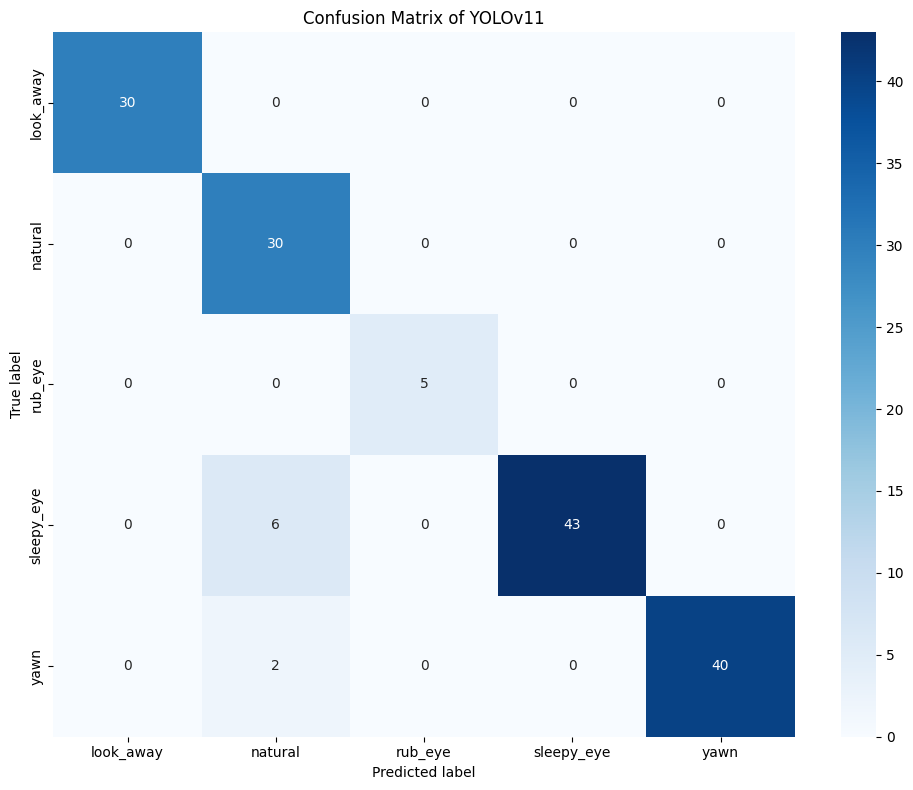

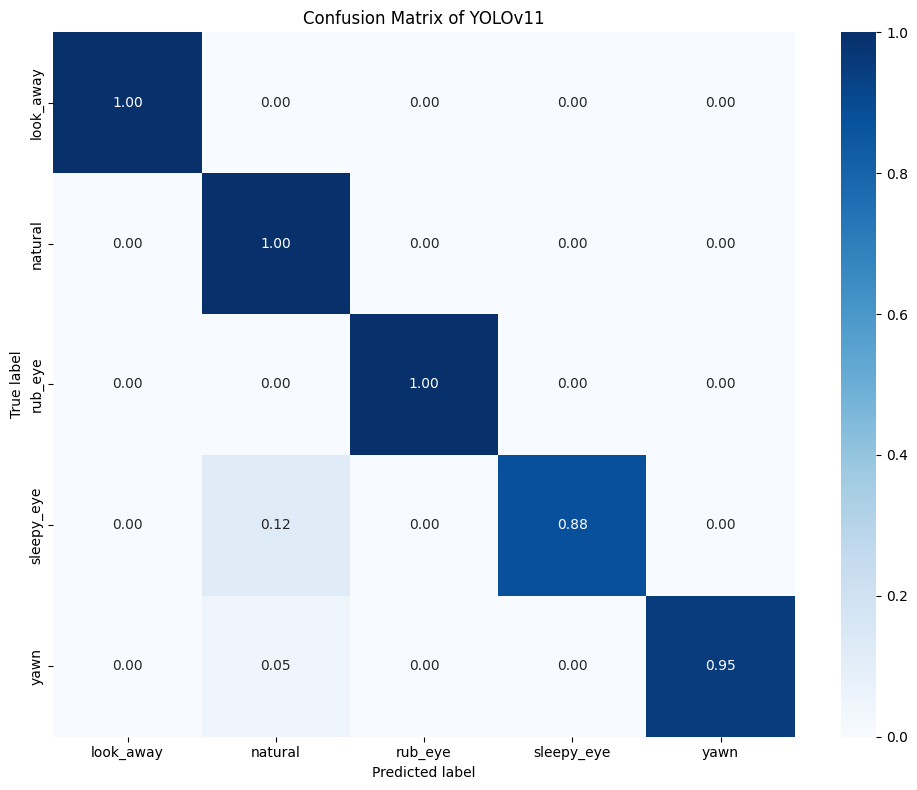

In [7]:
import pandas as pd
from ultralytics import YOLO
import time
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CẤU HÌNH ---
MODEL_PATH = "{HOME}/runs/detect/train/weights/best.pt"  # THAY THẾ BẰNG ĐƯỜNG DẪN ĐÚNG
CSV_PATH = "output_yolo.csv"          # THAY THẾ BẰNG ĐƯỜNG DẪN ĐÚNG
IMAGE_BASE_DIR = "" # Đặt thư mục gốc chứa thư mục 'test' nếu CSV không chứa đường dẫn tuyệt đối
                    # Ví dụ: nếu CSV có 'test/look_away/...' và script chạy từ thư mục cha của 'test', để trống.
                    # Nếu script chạy từ nơi khác, đặt IMAGE_BASE_DIR = "path/to/parent_of_test_folder"
OUTPUT_DIR = "yolo_evaluation_output"
CONFIDENCE_THRESHOLD = 0.25
SAVE_PREDICTED_IMAGES = True # Đặt thành False nếu không muốn lưu ảnh đã dự đoán

# --- HÀM HỖ TRỢ ---
def get_predicted_label(result, model_names, known_classes):
    """
    Trích xuất nhãn dự đoán từ kết quả của YOLO.
    Ưu tiên lớp có độ tin cậy cao nhất trong số các lớp đã biết.
    Nếu không có lớp nào được phát hiện hoặc không có lớp nào đã biết,
    có thể trả về một nhãn mặc định hoặc None.
    """
    pred_label_str = "unknown" # Nhãn mặc định nếu không có phát hiện phù hợp
    highest_confidence = 0.0

    if result.boxes and len(result.boxes.cls) > 0:
        for i in range(len(result.boxes.cls)):
            class_idx = int(result.boxes.cls[i])
            confidence = float(result.boxes.conf[i])
            class_name = model_names[class_idx]

            if class_name in known_classes: # Chỉ xem xét các lớp chúng ta quan tâm
                if confidence > highest_confidence:
                    highest_confidence = confidence
                    pred_label_str = class_name
    
    # Nếu không có detection nào thuộc known_classes, nhưng CSV có nhãn 'natural'
    # và chúng ta muốn mặc định là 'natural' nếu không có gì khác được phát hiện rõ ràng.
    # Điều này phụ thuộc vào logic của bạn.
    # Ví dụ: nếu pred_label_str vẫn là "unknown" và "natural" là một lựa chọn,
    # bạn có thể đặt nó là "natural".
    # Hiện tại, nếu không có detection thuộc known_classes, nó sẽ là "unknown".
    # Nếu bạn muốn nó là "natural" khi không có gì, bạn có thể thay đổi:
    if pred_label_str == "unknown" and "natural" in known_classes:
         # Kiểm tra xem có detection nào không, ngay cả khi không phải known_classes
        if not (result.boxes and len(result.boxes.cls) > 0) :
             pred_label_str = "natural" # Nếu không có bất kỳ detection nào, coi là natural
        # Hoặc nếu có detection nhưng không phải known_classes, vẫn là unknown hoặc logic khác

    return pred_label_str

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, output_path="confusion_matrix.png"):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Confusion matrix saved to {output_path}")
    # plt.show() # Bỏ comment nếu muốn hiển thị plot

# --- CHƯƠNG TRÌNH CHÍNH ---
def main():
    # 1. Chuẩn bị
    home_dir = HOME
    actual_model_path = MODEL_PATH.replace("{HOME}", home_dir)
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

    print(f"Loading model from: {actual_model_path}")
    if not os.path.exists(actual_model_path):
        print(f"LỖI: Model không tìm thấy tại: {actual_model_path}")
        return
    
    model = YOLO(actual_model_path)
    model_class_names = model.names # Đây là dict {index: 'name'}
    print(f"Model classes: {model_class_names}")

    print(f"Loading CSV from: {CSV_PATH}")
    if not os.path.exists(CSV_PATH):
        print(f"LỖI: CSV file không tìm thấy tại: {CSV_PATH}")
        return
    df = pd.read_csv(CSV_PATH)

    # Các lớp mục tiêu từ CSV (để đảm bảo chúng ta chỉ so sánh các lớp này)
    # Thường là các lớp trong các cột one-hot hoặc cột 'labels'
    target_classes = ['natural', 'sleepy_eye', 'yawn', 'rub_eye', 'look_away']
    # Kiểm tra xem các target_classes có trong model_class_names không
    for tc in target_classes:
        if tc not in model_class_names.values():
            print(f"CẢNH BÁO: Lớp '{tc}' từ CSV không có trong các lớp của model. Điều này có thể gây ra kết quả không chính xác.")


    true_labels_list = []
    predicted_labels_list = []
    inference_times = []

    print(f"\nBắt đầu dự đoán trên {len(df)} ảnh...")

    # 2. Lặp qua CSV và dự đoán
    for index, row in df.iterrows():
        image_path_relative = row['original_file_path']
        true_label = row['labels'] # Lấy nhãn dạng string

        if IMAGE_BASE_DIR:
            image_path_full = os.path.join(IMAGE_BASE_DIR, image_path_relative)
        else:
            image_path_full = image_path_relative # Giả sử đường dẫn đã đúng hoặc tương đối với thư mục chạy script

        if not os.path.exists(image_path_full):
            print(f"CẢNH BÁO: Ảnh không tìm thấy tại: {image_path_full}. Bỏ qua.")
            continue

        start_time = time.time()
        try:
            # predict() trả về một list các đối tượng Results. Với một ảnh, đó là list có 1 phần tử.
            results = model.predict(
                source=image_path_full,
                conf=CONFIDENCE_THRESHOLD,
                save=SAVE_PREDICTED_IMAGES, # YOLO sẽ lưu vào thư mục runs/detect/predictX
                project=OUTPUT_DIR, # Lưu các lần chạy predict vào thư mục con của OUTPUT_DIR
                name=f"predict_{Path(image_path_full).stem}", # Tên thư mục con cho lần predict này
                exist_ok=True, # Ghi đè nếu thư mục predict đã tồn tại
                verbose=False # Giảm output của YOLO
            )
        except Exception as e:
            print(f"Lỗi khi dự đoán ảnh {image_path_full}: {e}")
            continue

        end_time = time.time()
        inference_times.append(end_time - start_time)

        # results[0] vì chúng ta chỉ xử lý một ảnh mỗi lần
        predicted_label = get_predicted_label(results[0], model_class_names, target_classes)

        true_labels_list.append(true_label)
        predicted_labels_list.append(predicted_label)

        print(f"Ảnh: {Path(image_path_relative).name} - True: {true_label}, Predicted: {predicted_label} (Time: {end_time - start_time:.4f}s)")

    # 3. Tính toán và lưu trữ kết quả
    if not true_labels_list or not predicted_labels_list:
        print("Không có dự đoán nào được thực hiện. Kết thúc.")
        return

    print("\n--- KẾT QUẢ ĐÁNH GIÁ ---")

    # Lấy tất cả các nhãn duy nhất có thể có để CM được đầy đủ
    all_unique_labels = sorted(list(set(true_labels_list + predicted_labels_list)))
    
    # Nếu 'unknown' là một phần của all_unique_labels nhưng không phải là một target_class thực sự,
    # bạn có thể muốn loại bỏ nó khỏi báo cáo chi tiết nếu nó làm sai lệch F1 score,
    # hoặc đảm bảo nó được xử lý đúng cách.
    # Hiện tại, chúng ta sẽ bao gồm tất cả các nhãn đã xuất hiện.

    cm = confusion_matrix(true_labels_list, predicted_labels_list, labels=all_unique_labels)
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    
    # report_dict để dễ dàng truy cập các giá trị
    # zero_division=0 để tránh lỗi nếu có lớp không có trong dự đoán/nhãn thật
    report = classification_report(true_labels_list, predicted_labels_list, labels=all_unique_labels, zero_division=0, output_dict=True)
    report_str = classification_report(true_labels_list, predicted_labels_list, labels=all_unique_labels, zero_division=0)

    f1_macro = f1_score(true_labels_list, predicted_labels_list, average='macro', zero_division=0)
    f1_weighted = f1_score(true_labels_list, predicted_labels_list, average='weighted', zero_division=0)

    avg_inference_time = sum(inference_times) / len(inference_times) if inference_times else 0
    total_inference_time = sum(inference_times)

    print(f"Số lượng ảnh đã xử lý: {len(true_labels_list)}")
    print(f"Thời gian dự đoán trung bình mỗi ảnh: {avg_inference_time:.4f} giây")
    print(f"Tổng thời gian dự đoán: {total_inference_time:.4f} giây")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    print("\nConfusion Matrix:")
    # In CM dưới dạng text
    cm_df = pd.DataFrame(cm, index=all_unique_labels, columns=all_unique_labels)
    print(cm_df)

    print("\nClassification Report:")
    print(report_str)

    # Lưu kết quả vào file text
    results_summary_path = os.path.join(OUTPUT_DIR, "evaluation_summary.txt")
    with open(results_summary_path, "w", encoding="utf-8") as f:
        f.write("--- KẾT QUẢ ĐÁNH GIÁ YOLO MODEL ---\n")
        f.write(f"Model Path: {actual_model_path}\n")
        f.write(f"CSV Path: {CSV_PATH}\n")
        f.write(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}\n")
        f.write(f"Số lượng ảnh đã xử lý: {len(true_labels_list)}\n")
        f.write(f"Thời gian dự đoán trung bình mỗi ảnh: {avg_inference_time:.4f} giây\n")
        f.write(f"Tổng thời gian dự đoán: {total_inference_time:.4f} giây\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"F1 Score (Macro): {f1_macro:.4f}\n")
        f.write(f"F1 Score (Weighted): {f1_weighted:.4f}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(cm_df.to_string() + "\n\n")
        f.write("Classification Report:\n")
        f.write(report_str + "\n")
    print(f"\nKết quả tóm tắt đã được lưu vào: {results_summary_path}")

    # Vẽ và lưu confusion matrix
    cm_plot_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
    plot_confusion_matrix(cm, classes=all_unique_labels, title='Confusion Matrix of YOLOv11', output_path=cm_plot_path)

    cm_norm_plot_path = os.path.join(OUTPUT_DIR, "confusion_matrix_normalized.png")
    plot_confusion_matrix(cm, classes=all_unique_labels, normalize=True, title='Confusion Matrix of YOLOv11', output_path=cm_norm_plot_path)

    print(f"\nĐã hoàn thành. Ảnh đã dự đoán (nếu SAVE_PREDICTED_IMAGES=True) được lưu trong các thư mục con của '{OUTPUT_DIR}'.")

if __name__ == '__main__':
    main()

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=rub_eye-tuan save=True